# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

In [210]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns

from geopy.distance import geodesic

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

2. Пройдите по основным шагам работы с данными: 
    - выкиньте ненужные признаки: id, name, host_id, host_name, last_review
    - визуализируйте базовые статистики данных: распределения признаков, матрицу попарных корреляций, постройте pair plots
    - по результатам анализа произведите предобработку переменных

In [211]:
# 1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
data = pd.read_csv("AB_NYC_2019.csv")
# - выкиньте ненужные признаки: id, name, host_id, host_name, last_review
data.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
data.head(10)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129
6,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,0.40,1,0
7,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,3.47,1,220
8,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,0.99,1,0
9,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,1.33,4,188


C:\Users\sergu\AppData\Local\Temp\ipykernel_27572\816540768.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i, j].legend()


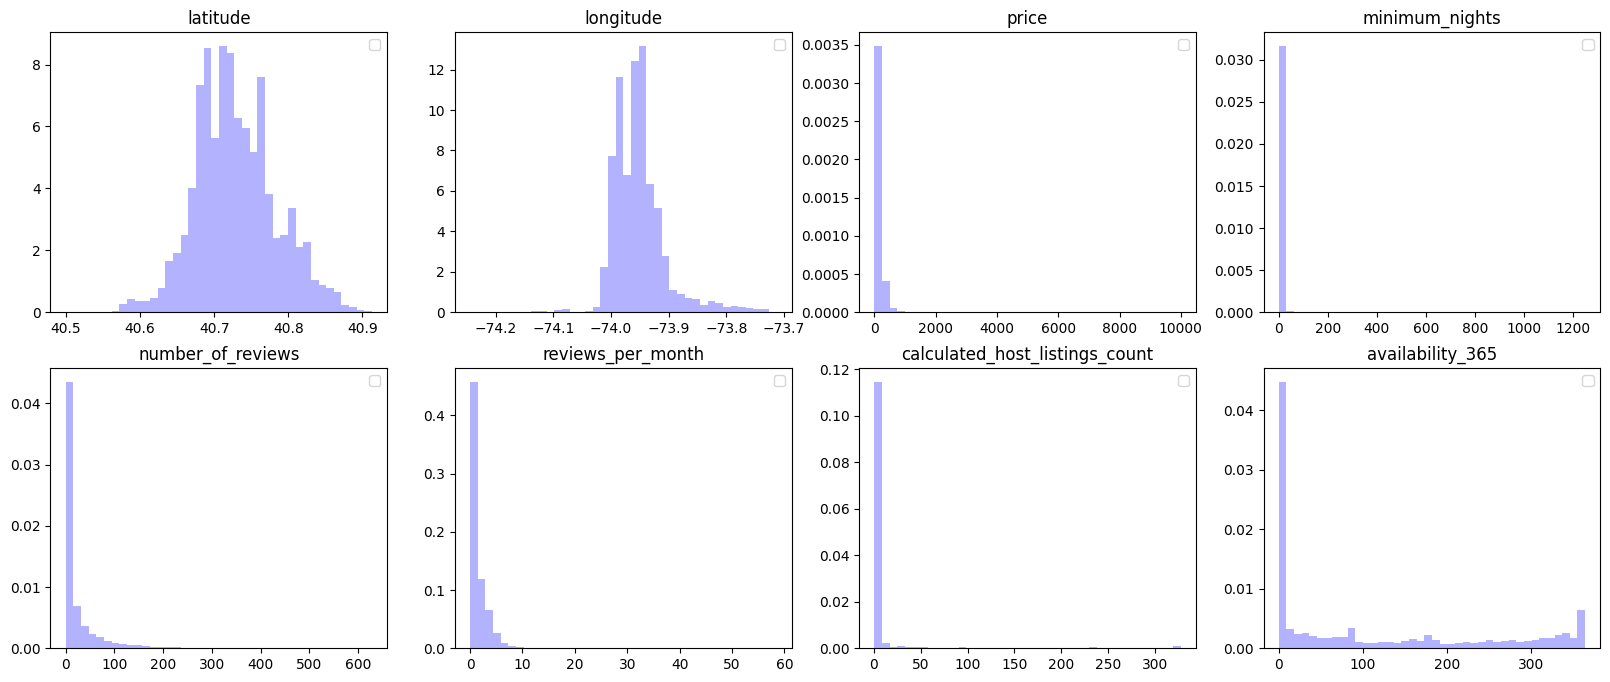

In [212]:
# - визуализируйте базовые статистики данных: распределения признаков
columns = data.select_dtypes(include='number').columns.to_list()

kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)
coln = 0
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(2):
    for j in range(4):
        ax[i, j].hist(data[columns[coln]], color='blue', **kwargs)
        ax[i, j].legend()
        ax[i, j].set_title(columns[coln])
        coln = coln + 1

In [213]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Для большинства данных (price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count) видим неравномерные распределения, есть большой разброс. Например, 75% цен в диапазоне до 175, но есть и 10000. Можно конечно считать это зааномалии, но это реальные цены за роскошные аппартаменты.

In [214]:
data[data["price"]>=9000]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
6530,Manhattan,East Harlem,40.79264,-73.93898,Entire home/apt,9999,5,1,0.02,1,0
9151,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,0.04,1,0
12342,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,0.14,1,83
17692,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,0.16,1,0
29238,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,NaN,1,83
40433,Manhattan,Lower East Side,40.71980,-73.98566,Entire home/apt,9999,30,0,NaN,1,365


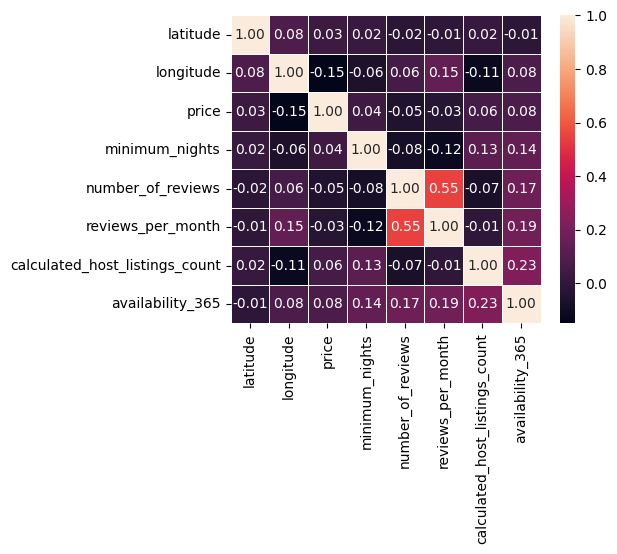

In [215]:
# - визуализируйте базовые статистики данных: матрицу попарных корреляций
plt.figure(figsize=(5, 4))
sns.heatmap(data[['latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']].corr(), annot=True, cbar=True, linewidths=.5, fmt= '.2f')
plt.show()
# 1                 Абсолютная прямая положительная связь (чем больше X, тем больше Y)
# от 0,7 до 0,9     Сильная положительная связь
# от 0,4 до 0,6     Умеренная связь
# от 0 до 0,4       Нет линейной связи
# от -0,4 до -0,7   Умеренная обратная связь (чем больше X, тем меньше Y)
# от -0,7 до -0,9   Сильная обратная связь
# -1                Абсолютная обратная связь

Очевдна корреляция мжду количеством просмотров и количеством просмотров в месяц -> что то одно теоретически можно убрать.

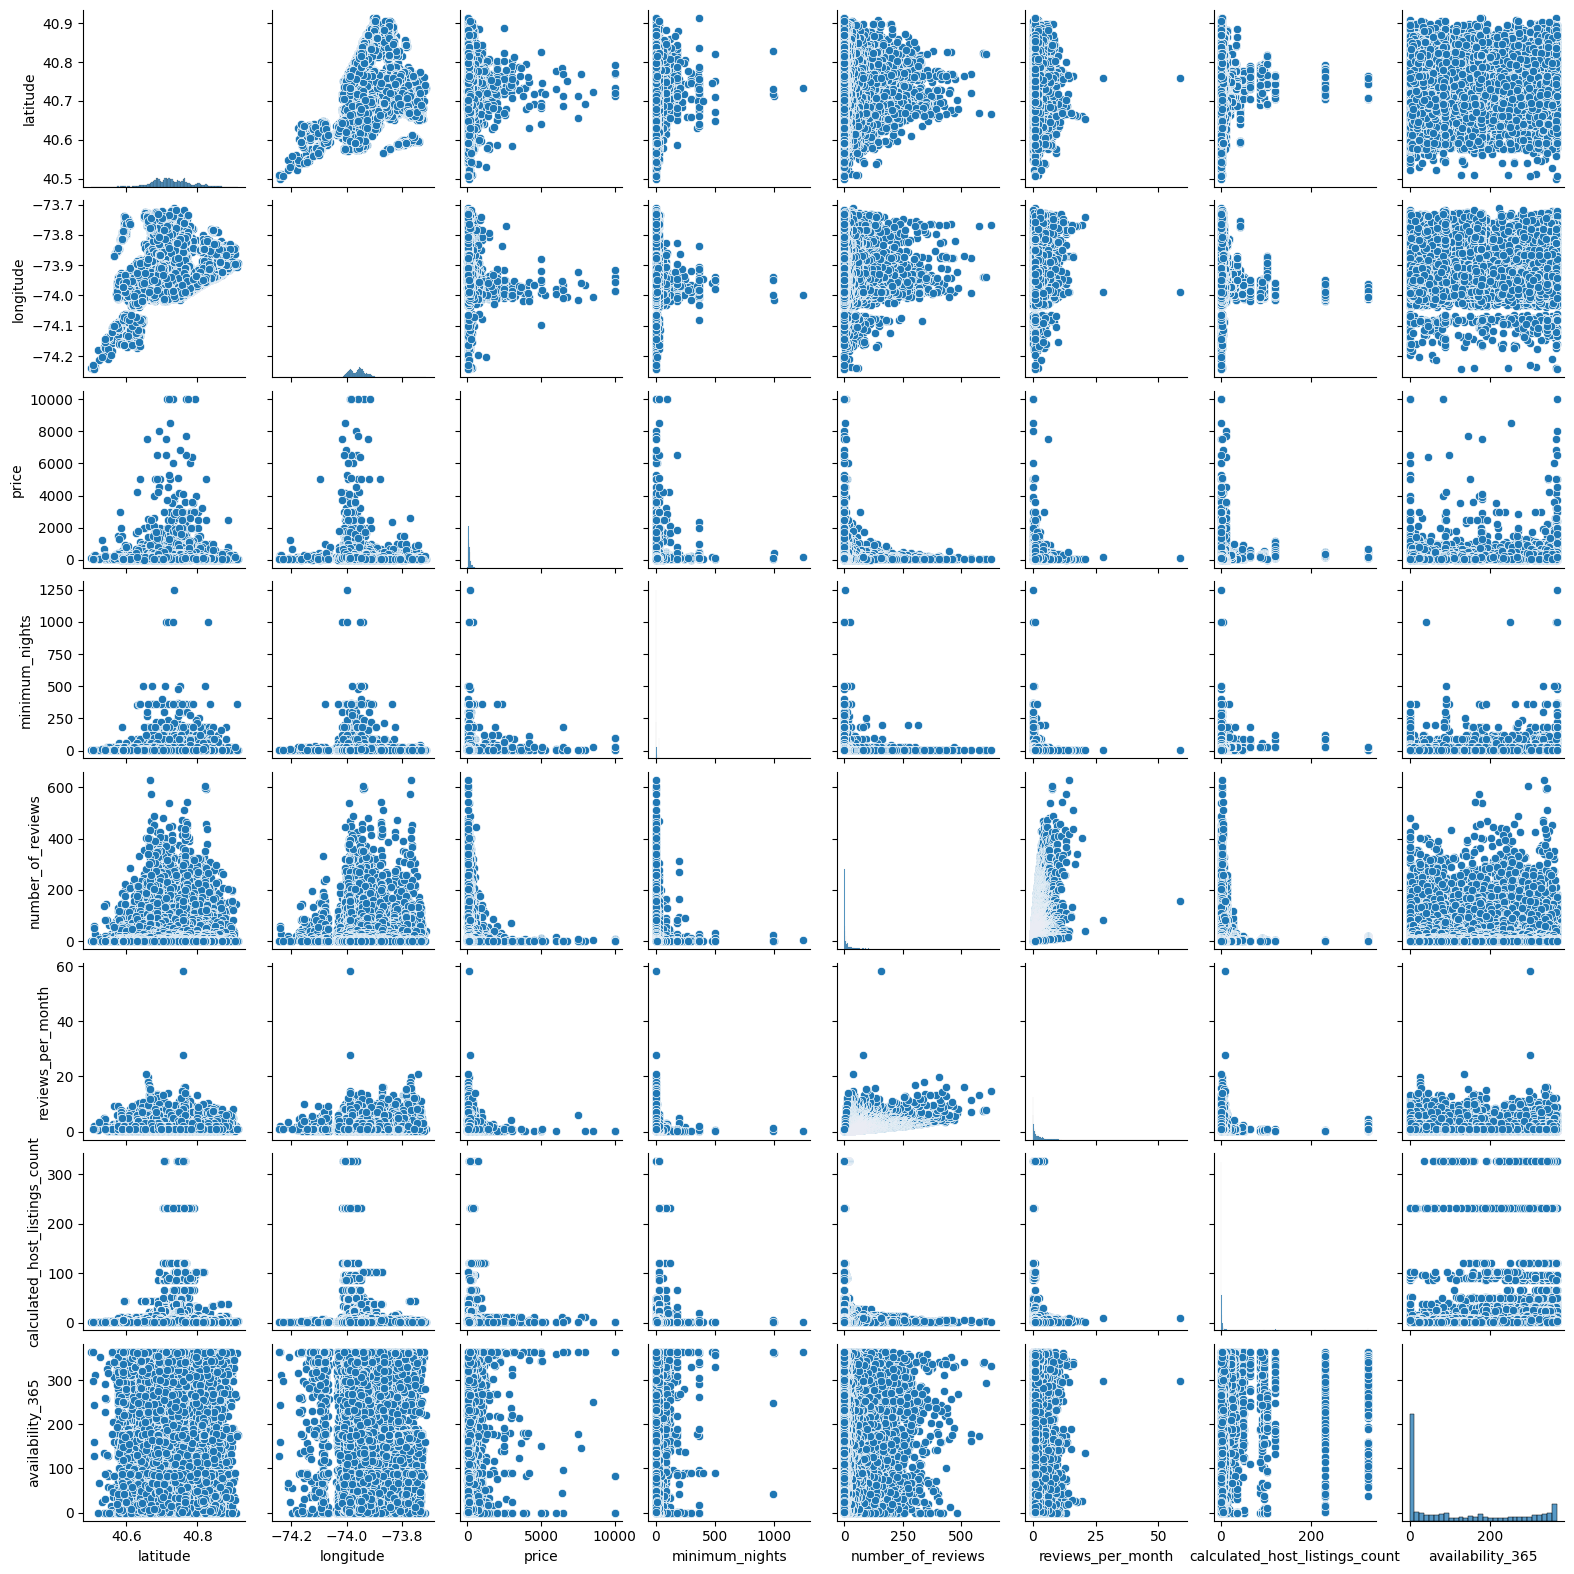

In [216]:
# - визуализируйте базовые статистики данных: постройте pair plots
sns.pairplot(data, height=2)

pair plots подтверждает линейную зависимость общего числа просмотров и просмотров за месяц. Разумееется, "зависимость" видна между широтой и долготой.
Также, видим рост цены, количества просмотров и квартиросъёмщиков в определенном районе судя по концентрации в широте и долготе.

Пред тем как выполнимть преобработку данных, разделим наш датасет на Train и Test чтобы не было "утечки таргета" (информация из Test косвенно не переносилась в Train). 
Предобработаем Train, а готовые трансформеры потом применим на Test.

In [217]:
X = data.drop('price', axis=1)
Y = data['price']
# 1. Отложите 30% данных для тестирования.
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state= 42, train_size=0.7,shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34226, 10), (14669, 10), (34226,), (14669,))

In [218]:
total_missed = float(pd.DataFrame(X_train.isnull().sum(),
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/X_train.shape[0]*100) \
    .sum()['missing_pct'])
print(f"Всего проусков {total_missed}%")
# Number of nulls
pd.DataFrame(X_train.isnull().sum(),
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/X_train.shape[0]*100).astype(float).round(1)

Всего проусков 20.621749547127916%


,missing_count,missing_pct
neighbourhood_group,0.0,0.0
neighbourhood,0.0,0.0
latitude,0.0,0.0
longitude,0.0,0.0
room_type,0.0,0.0
minimum_nights,0.0,0.0
number_of_reviews,0.0,0.0
reviews_per_month,7058.0,20.6
calculated_host_listings_count,0.0,0.0
availability_365,0.0,0.0


Видим 20% пропущенных данных приходится на просмотры за месяц. Т.к. максимальное = 58.5, то средним тем более не имеет смысла заполнять и поэтому заполняем их нулём.

In [219]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train[['reviews_per_month']]=imp.fit_transform(X_train[['reviews_per_month']])

pd.DataFrame(X_train.isnull().sum(),
            columns = ['missing_count']) \
.assign(missing_pct = lambda x: x['missing_count']/X_train.shape[0]*100).astype(float).round(1)

,missing_count,missing_pct
neighbourhood_group,0.0,0.0
neighbourhood,0.0,0.0
latitude,0.0,0.0
longitude,0.0,0.0
room_type,0.0,0.0
minimum_nights,0.0,0.0
number_of_reviews,0.0,0.0
reviews_per_month,0.0,0.0
calculated_host_listings_count,0.0,0.0
availability_365,0.0,0.0


**Часть 2. Preprocessing & Feature Engineering**

Ваша цель — получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.
<br>
Опробуйте различные техники:
   - работа с категориальными переменными (можно начать с dummy);
   - замена аномалий;
   - различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler и т. д.);
   - обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать;
<br>
Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели. Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы, а также евклидова расстояния создать новую переменную — расстояние от квартиры до этого района. Возможно, такой признак будет работать лучше, чем просто широта и долгота. 

In [220]:
categorical_features = X_train.select_dtypes(include = ['object']).columns.to_list()
categorical_features

['neighbourhood_group', 'neighbourhood', 'room_type']

Поле "room_type" составное и поэтому разделим его на два чтобы выделить недвижимость позиционирующуюся как аппартаменты.

Далее, разделим первую часть чтобы отделить частное\общее и дом\комната.


In [221]:
# заполняем столбцы room_type
for i, _ in enumerate(X_train['room_type'].str.split("/",expand=True)):
    X_train['room_type_' + str(i+1)] = X_train['room_type'].str.split("/", expand=True)[i]

X_train['room_type_2'] = X_train['room_type_2'].astype(str)
X_train.drop('room_type', axis=1, inplace=True)

for i, _ in enumerate(X_train['room_type_1'].str.split(" ",expand=True)):
    X_train['room_type_1' + str(i)] = X_train['room_type_1'].str.split(" ", expand=True)[i]

X_train['room_type_11'] = X_train['room_type_11'].astype(str)
X_train.drop('room_type_1', axis=1, inplace=True)

X_train.head(10)

,neighbourhood_group,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_2,room_type_10,room_type_11
21681,Queens,Cambria Heights,40.69206,-73.74546,2,65,2.33,1,263,apt,Entire,home
26482,Brooklyn,Sunset Park,40.66060,-73.99455,2,24,1.15,1,12,apt,Entire,home
20859,Manhattan,Kips Bay,40.74227,-73.97432,5,2,0.07,1,0,None,Private,room
45464,Brooklyn,Bedford-Stuyvesant,40.68676,-73.94593,1,4,2.86,3,0,None,Private,room
22583,Manhattan,Midtown,40.76013,-73.96566,3,6,0.24,1,0,None,Shared,room
9937,Brooklyn,Red Hook,40.67791,-74.00720,5,5,0.10,1,0,None,Private,room
27275,Manhattan,East Village,40.72834,-73.97907,30,0,0.00,1,119,apt,Entire,home
38199,Manhattan,Hell's Kitchen,40.76207,-73.98935,1,51,7.50,1,25,apt,Entire,home
31905,Brooklyn,Clinton Hill,40.68409,-73.96467,7,2,0.88,1,89,None,Private,room
5157,Manhattan,East Village,40.72669,-73.98419,2,179,2.99,1,179,apt,Entire,home


Сделаем Pipeline чтобы был автомат получения из исходного датасета в готовый для моделирования.

Feature engineering

In [222]:
# Вместо координат (сомнительные фичи) добавим расстояние до центра и трёх популярных районов
# Координаты центра Нью-Йорка (например, Таймс-Сквер)
center = (40.7580, -73.9855)
# Координаты районов
manhattan = (40.7831, -73.9712)
brooklyn = (40.6782, -73.9442)
queens = (40.7420, -73.8241)

coords = (40.68676, -73.94593)
# Вычисление расстояния
data["distance_manhattan"] = data.apply(lambda x: geodesic((x["latitude"],x["longitude"]), manhattan).km, axis=1)
data["distance_brooklyn"] = data.apply(lambda x: geodesic((x["latitude"],x["longitude"]), brooklyn).km, axis=1)
data["distance_queens"] = data.apply(lambda x: geodesic((x["latitude"],x["longitude"]), queens).km, axis=1)
data["distance_center"] = data.apply(lambda x: geodesic((x["latitude"],x["longitude"]), center).km, axis=1)
data.drop(['latitude', 'longitude'], axis=1, inplace=True)

data.head(10)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance_manhattan,distance_brooklyn,distance_queens,distance_center
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365,15.059599,4.159859,16.346299,12.321998
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355,3.441461,9.017985,13.546535,0.507861
2,Manhattan,Harlem,Private room,150,3,0,NaN,1,365,3.794698,14.528723,12.421271,6.756122
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194,10.921176,1.524555,13.087041,8.378165
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0,2.864014,13.360299,11.909398,5.702325
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,0.59,1,129,3.947540,8.141705,12.760378,1.449890
6,Brooklyn,Bedford-Stuyvesant,Private room,60,45,49,0.40,1,0,10.762384,1.384720,12.712447,8.282728
7,Manhattan,Hell's Kitchen,Private room,79,2,430,3.47,1,220,2.330855,10.223362,13.817578,0.766642
8,Manhattan,Upper West Side,Private room,79,2,118,0.99,1,0,2.101298,13.860599,13.787157,5.100509
9,Manhattan,Chinatown,Entire home/apt,150,1,160,1.33,4,188,7.903279,5.526510,14.400163,4.965404


In [223]:
# price Group
# Решение интересное, но не будет ли "утечка таргета"? С одной стороны группы и не должно, но сдругой косвено цена задействована.
data['priceGroup'] = pd.cut(data['price'], bins=[0, 2000, 4000, 6000, 8000, 10000], labels=['price_2000','price_4000', 'price_6000','price_8000','price_10000'])
#data.groupby('priceGroup').count()

In [224]:
# Убираем аномалии - по паре значений далеко за максимальным в распределении
data = data[data['reviews_per_month'] < 22]
data = data[data['minimum_nights'] <= 900]

In [225]:
# Имеем 235 значений больше максимального. Теоретически их можно удалить или заменить на, например, максимальное в нормальной группе.
# Вопрос: а нужно ли? Не убъём ли мы срез данных где важнол количество жильцов?
data[data['calculated_host_listings_count'] >= 200]

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance_manhattan,distance_brooklyn,distance_queens,distance_center,priceGroup
29128,Manhattan,Financial District,Entire home/apt,271,30,1,0.09,232,310,9.111448,6.337722,16.148138,6.078813,price_2000
30428,Manhattan,Murray Hill,Entire home/apt,305,30,1,0.17,232,326,3.851611,8.380921,13.094072,1.154313,price_2000
32788,Manhattan,Upper East Side,Entire home/apt,211,30,1,0.23,232,201,1.413756,10.988287,11.843367,3.195011,price_2000
34048,Manhattan,Theater District,Entire home/apt,280,30,2,0.36,232,218,2.634434,9.930269,13.797573,0.439914,price_2000
35411,Manhattan,Financial District,Entire home/apt,285,30,1,0.12,232,324,9.336652,6.243216,16.225864,6.305509,price_2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44346,Manhattan,Financial District,Entire home/apt,247,2,4,2.35,327,232,9.215594,6.565415,16.406527,6.178930,price_2000
44534,Manhattan,Financial District,Entire home/apt,100,29,1,0.88,327,358,8.783633,6.114682,15.721177,5.760691,price_2000
44670,Manhattan,Financial District,Entire home/apt,179,29,1,1.00,327,339,8.841634,6.118789,15.768203,5.817881,price_2000
45148,Manhattan,Financial District,Entire home/apt,222,2,1,0.73,327,315,9.190644,6.411101,16.263645,6.156214,price_2000


In [226]:
unique_counts = data.groupby('neighbourhood')['neighbourhood'].nunique()
print(unique_counts)
# 218 - значит просто кодируем

neighbourhood
Allerton           1
Arden Heights      1
Arrochar           1
Arverne            1
Astoria            1
                  ..
Willowbrook        1
Windsor Terrace    1
Woodhaven          1
Woodlawn           1
Woodside           1
Name: neighbourhood, Length: 218, dtype: int64


In [227]:
unique_counts = data.groupby('neighbourhood_group')['neighbourhood'].nunique()
print(unique_counts)
# 5 значений - значит one-hot

neighbourhood_group
Bronx            48
Brooklyn         47
Manhattan        32
Queens           51
Staten Island    40
Name: neighbourhood, dtype: int64


In [228]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, handle_unknown='ignore'):
        self.columns = columns
        self.handle_unknown = handle_unknown
        self.encoder = None

    def fit(self, X, y=None):
        if self.columns is None:
            # If no columns specified, encode all object/categorical columns
            categorical_cols = X.select_dtypes(include=['object', 'category']).columns
            self.columns = categorical_cols
        
        # Initialize and fit the OneHotEncoder on the specified columns
        self.encoder = OneHotEncoder(handle_unknown=self.handle_unknown, sparse_output=False)
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        # Create a copy to avoid modifying original DataFrame
        #X_transformed = X.copy()
        
        # Transform the specified columns
        #encoded_data = self.encoder.transform(X_transformed[self.columns])
        encoded_data = self.encoder.transform(X[self.columns])
        
        # Get feature names for the new columns
        feature_names = self.encoder.get_feature_names_out(self.columns)
        encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=X.index)
        #encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=X_transformed.index)
        
        # Drop original columns and concatenate encoded columns
        X = X.drop(columns=self.columns)
        X = pd.concat([X, encoded_df], axis=1)
        return X
        # X_transformed = X_transformed.drop(columns=self.columns)
        # X_transformed = pd.concat([X_transformed, encoded_df], axis=1)
        # return X_transformed


# Реализуем кастомный класс т.к. необходимо делать сплит данных, вычисление расстояния по двум столбцам и т.д., что не вписывается в стардартные функции\трансформеры sklearn pipeline
class AB_NYC_2019_class(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop, regularization, priceGroupUse = False):
        self.pipeline = None
        self.feature_names = None
        self.priceGroupUse = priceGroupUse
        self.columns_to_drop = columns_to_drop
        self.regularization = regularization
        if self.regularization == 'LinearRegression':
            self.pipeline = Pipeline([
                ('LinearRegression', LinearRegression())
            ])
        if self.regularization == 'RidgeCV':
            self.pipeline = Pipeline([
                ('RidgeCV', RidgeCV())
            ])
        if self.regularization == 'LassoCV':
            self.pipeline = Pipeline([
                ('LassoCV', LassoCV())
            ])        
        if self.regularization == 'ElasticNetCV':
            self.pipeline = Pipeline([
                ('ElasticNetCV', ElasticNetCV())
            ])


    def fit(self, X, y=None):
        # ft = self.pipeline.fit(X, y)
        self.feature_names = X.columns
        self.pipeline.fit(X, y)

        # Возвращаем self !!! Т.к. для predict нужен transform, а если вернём ft то вызовется predict базового класса, transform не случится и несовпадение столбцов
        return self # ft

    def transform(self, X):
        # Ensure X is a DataFrame for column dropping
        if isinstance(X, pd.DataFrame):
            # - выкиньте ненужные признаки: id, name, host_id, host_name, last_review
            X.drop(self.columns_to_drop, axis=1, inplace=True)

            imp = SimpleImputer(strategy='constant', fill_value=0)
            X[['reviews_per_month']]=imp.fit_transform(X[['reviews_per_month']])

            # заполняем столбцы room_type
            for i, _ in enumerate(X['room_type'].str.split("/",expand=True)):
                X['room_type_' + str(i+1)] = X['room_type'].str.split("/", expand=True)[i]

            X['room_type_2'] = X['room_type_2'].astype(str)
            X.drop('room_type', axis=1, inplace=True)

            for i, _ in enumerate(X['room_type_1'].str.split(" ",expand=True)):
                X['room_type_1' + str(i)] = X['room_type_1'].str.split(" ", expand=True)[i]

            X['room_type_11'] = X['room_type_11'].astype(str)
            X.drop('room_type_1', axis=1, inplace=True)

            # Вместо координат (сомнительные фичи) добавим расстояние до центра и трёх популярных районов
            # Координаты центра Нью-Йорка (например, Таймс-Сквер)
            center = (40.7580, -73.9855)
            # Координаты районов
            manhattan = (40.7831, -73.9712)
            brooklyn = (40.6782, -73.9442)
            queens = (40.7420, -73.8241)

            # Вычисление расстояния
            X["distance_manhattan"] = X.apply(lambda X: geodesic((X["latitude"],X["longitude"]), manhattan).km, axis=1)
            X["distance_brooklyn"] = X.apply(lambda X: geodesic((X["latitude"],X["longitude"]), brooklyn).km, axis=1)
            X["distance_queens"] = X.apply(lambda X: geodesic((X["latitude"],X["longitude"]), queens).km, axis=1)
            X["distance_center"] = X.apply(lambda X: geodesic((X["latitude"],X["longitude"]), center).km, axis=1)
            X.drop(['latitude', 'longitude'], axis=1, inplace=True)

            # price Group
            # Решение интересное, но не будет ли "утечка таргета"? С одной стороны группы и не должно, но сдругой косвено цена задействована.
            if self.priceGroupUse:
                X['priceGroup'] = pd.cut(X['price'], bins=[0, 2000, 4000, 6000, 8000, 10000], labels=['price_2000','price_4000', 'price_6000','price_8000','price_10000']).astype(str)
            X.drop('price', axis=1, inplace=True)

            X = X[X['reviews_per_month'] < 22]
            X = X[X['minimum_nights'] < 900]

            ord = OrdinalEncoder()
            # 218 значений - значит просто кодируем Ordinal
            X[['neighbourhood_enc']] = ord.fit_transform(X[['neighbourhood']])
            X.drop('neighbourhood', axis=1, inplace=True)

            numerical_features = X.select_dtypes(include=np.number).columns.tolist()
            categorical_features = X.select_dtypes(include = ['object']).columns.to_list()

            std_sc = StandardScaler()
            for fiture in numerical_features:
                X[[fiture]] = std_sc.fit_transform(X[[fiture]])

            ohe_pipeline = Pipeline([
                ('custom_ohe', CustomOneHotEncoder(columns=categorical_features, handle_unknown='ignore'))
            ])

            X = ohe_pipeline.fit_transform(X)            

            return X
        else:
            # Handle cases where X might be a NumPy array if needed
            raise TypeError("Input must be a pandas DataFrame for this transformer.")

    def fit_transform(self, X, y=None):
        Xt = self.transform(X)
        y = y[y.index.isin(Xt.index)] # Убрали строки с удаленными из фич аномалиями
        # print("fit_transform")
        # print("Xt",Xt.columns)
        ft = self.fit(Xt, y)

        return ft

    def predict(self, X):
        Xt = self.transform(X)
        # print("predict")
        # print("Xt",Xt.columns)
        pft = self.pipeline.predict(Xt)

        dfp = pd.DataFrame(pft, index=X.index)
        # print(len(Xt), len(pft), len(dfp))

        return dfp

**Часть 3. Моделирование**

1. Отложите 30% данных для тестирования.
2. Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.
3. Измерьте качество каждой и визуализируйте важность признаков.
4. Сделайте интересные выводы :)

LinearRegression MSE = 14706.7715
LinearRegression MAE = 61.3580
LinearRegression MAPE = 11518400628179.1270
LinearRegression R2 = 0.6359
RidgeCV MSE = 14716.1909
RidgeCV MAE = 61.3768
RidgeCV MAPE = 15520706080435.0723
RidgeCV R2 = 0.6356
LassoCV MSE = 14756.9516
LassoCV MAE = 61.4047
LassoCV MAPE = 86806261061847.8906
LassoCV R2 = 0.6346
ElasticNetCV MSE = 32790.1266
ElasticNetCV MAE = 69.4308
ElasticNetCV MAPE = 147866106470513.8750
ElasticNetCV R2 = 0.1881


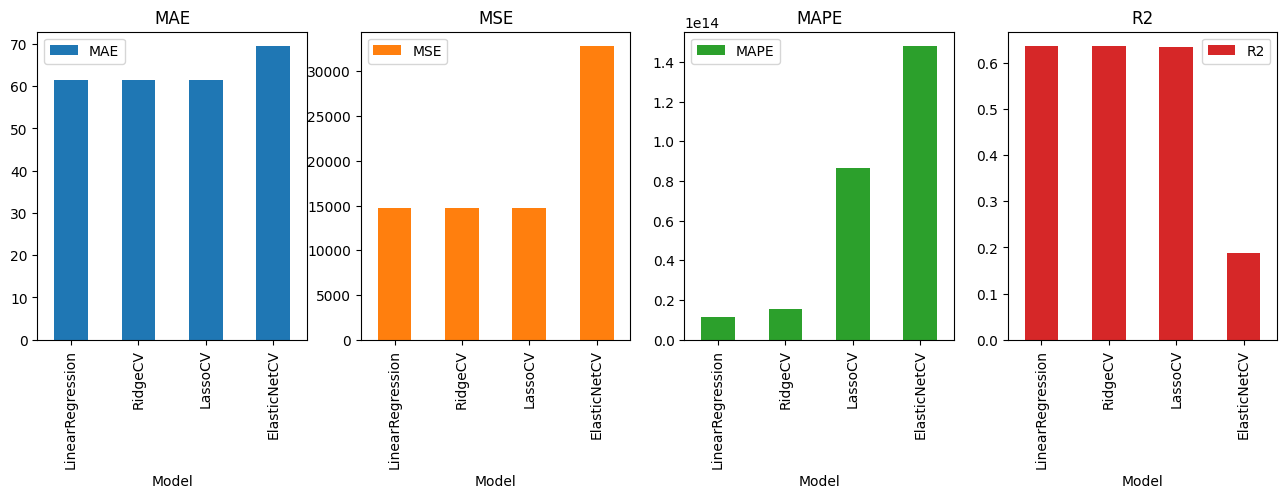

In [229]:
data = pd.read_csv("AB_NYC_2019.csv")

# 1. Отложите 30% данных для тестирования.
X_train, X_test, y_train, y_test = train_test_split(data, data['price'], random_state = 42, train_size=0.7, shuffle=True)

# 2. Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.

# Create an instance of the custom transformer
AB_NYC_2019 = AB_NYC_2019_class(columns_to_drop=['id', 'name', 'host_id', 'host_name', 'last_review'], regularization = 'LinearRegression', priceGroupUse = True)

pipeline = Pipeline([
    ('AB_NYC_2019', AB_NYC_2019)
])

ft = pipeline.fit_transform(X_train.copy(), y_train.copy())
y_pred = ft.predict(X_test.copy())

MSE_LinearRegression = mean_squared_error(y_test, y_pred)
MAE_LinearRegression = mean_absolute_error(y_test, y_pred)
MAPE_LinearRegression = mean_absolute_percentage_error(y_test, y_pred)
R2_LinearRegression = r2_score(y_test, y_pred)
coef_LinearRegression = ft.pipeline.named_steps['LinearRegression'].coef_

print("LinearRegression MSE = %.4f" % MSE_LinearRegression)
print("LinearRegression MAE = %.4f" % MAE_LinearRegression)
print("LinearRegression MAPE = %.4f" % MAPE_LinearRegression)
print("LinearRegression R2 = %.4f" % R2_LinearRegression)

AB_NYC_2019= AB_NYC_2019_class(columns_to_drop=['id', 'name', 'host_id', 'host_name', 'last_review'], regularization = 'RidgeCV', priceGroupUse = True)

pipeline = Pipeline([
    ('AB_NYC_2019', AB_NYC_2019)
])

ft = pipeline.fit_transform(X_train.copy(), y_train.copy())
y_pred = ft.predict(X_test.copy())

MSE_RidgeCV = mean_squared_error(y_test, y_pred)
MAE_RidgeCV = mean_absolute_error(y_test, y_pred)
MAPE_RidgeCV = mean_absolute_percentage_error(y_test, y_pred)
R2_RidgeCV = r2_score(y_test, y_pred)
coef_RidgeCV = ft.pipeline.named_steps['RidgeCV'].coef_

print("RidgeCV MSE = %.4f" % MSE_RidgeCV)
print("RidgeCV MAE = %.4f" % MAE_RidgeCV)
print("RidgeCV MAPE = %.4f" % MAPE_RidgeCV)
print("RidgeCV R2 = %.4f" % R2_RidgeCV)

AB_NYC_2019= AB_NYC_2019_class(columns_to_drop=['id', 'name', 'host_id', 'host_name', 'last_review'], regularization = 'LassoCV', priceGroupUse = True)

pipeline = Pipeline([
    ('AB_NYC_2019', AB_NYC_2019)
])

ft = pipeline.fit_transform(X_train.copy(), y_train.copy())
y_pred = ft.predict(X_test.copy())

MSE_LassoCV = mean_squared_error(y_test, y_pred)
MAE_LassoCV = mean_absolute_error(y_test, y_pred)
MAPE_LassoCV = mean_absolute_percentage_error(y_test, y_pred)
R2_LassoCV = r2_score(y_test, y_pred)
coef_LassoCV = ft.pipeline.named_steps['LassoCV'].coef_

print("LassoCV MSE = %.4f" % MSE_LassoCV)
print("LassoCV MAE = %.4f" % MAE_LassoCV)
print("LassoCV MAPE = %.4f" % MAPE_LassoCV)
print("LassoCV R2 = %.4f" % R2_LassoCV)

AB_NYC_2019= AB_NYC_2019_class(columns_to_drop=['id', 'name', 'host_id', 'host_name', 'last_review'], regularization = 'ElasticNetCV', priceGroupUse = True)

pipeline = Pipeline([
    ('AB_NYC_2019', AB_NYC_2019)
])

ft = pipeline.fit_transform(X_train.copy(), y_train.copy())
y_pred = ft.predict(X_test.copy())

MSE_ElasticNetCV = mean_squared_error(y_test, y_pred)
MAE_ElasticNetCV = mean_absolute_error(y_test, y_pred)
MAPE_ElasticNetCV = mean_absolute_percentage_error(y_test, y_pred)
R2_ElasticNetCV = r2_score(y_test, y_pred)
coef_ElasticNetCV = ft.pipeline.named_steps['ElasticNetCV'].coef_

print("ElasticNetCV MSE = %.4f" % MSE_ElasticNetCV)
print("ElasticNetCV MAE = %.4f" % MAE_ElasticNetCV)
print("ElasticNetCV MAPE = %.4f" % MAPE_ElasticNetCV)
print("ElasticNetCV R2 = %.4f" % R2_ElasticNetCV)

scores = pd.DataFrame({'Model': ['LinearRegression', 'RidgeCV', 'LassoCV', 'ElasticNetCV'], 
                       'MAE': [MAE_LinearRegression, MAE_RidgeCV, MAE_LassoCV, MAE_ElasticNetCV], 
                       'MSE': [MSE_LinearRegression, MSE_RidgeCV, MSE_LassoCV, MSE_ElasticNetCV], 
                       'MAPE': [MAPE_LinearRegression, MAPE_RidgeCV, MAPE_LassoCV, MAPE_ElasticNetCV], 
                       'R2': [R2_LinearRegression, R2_RidgeCV, R2_LassoCV, R2_ElasticNetCV]})

scores.plot.bar(subplots=True, layout=(1, 4), figsize=(16, 4), x='Model', y=['MAE', 'MSE', 'MAPE', 'R2'])
plt.show()


Видим что простая 'LinearRegression' даёт минимальную ошибку и максимальный R2 без всяких регуляризаций.

Посмотрим на влияние\важность признаков\фич:

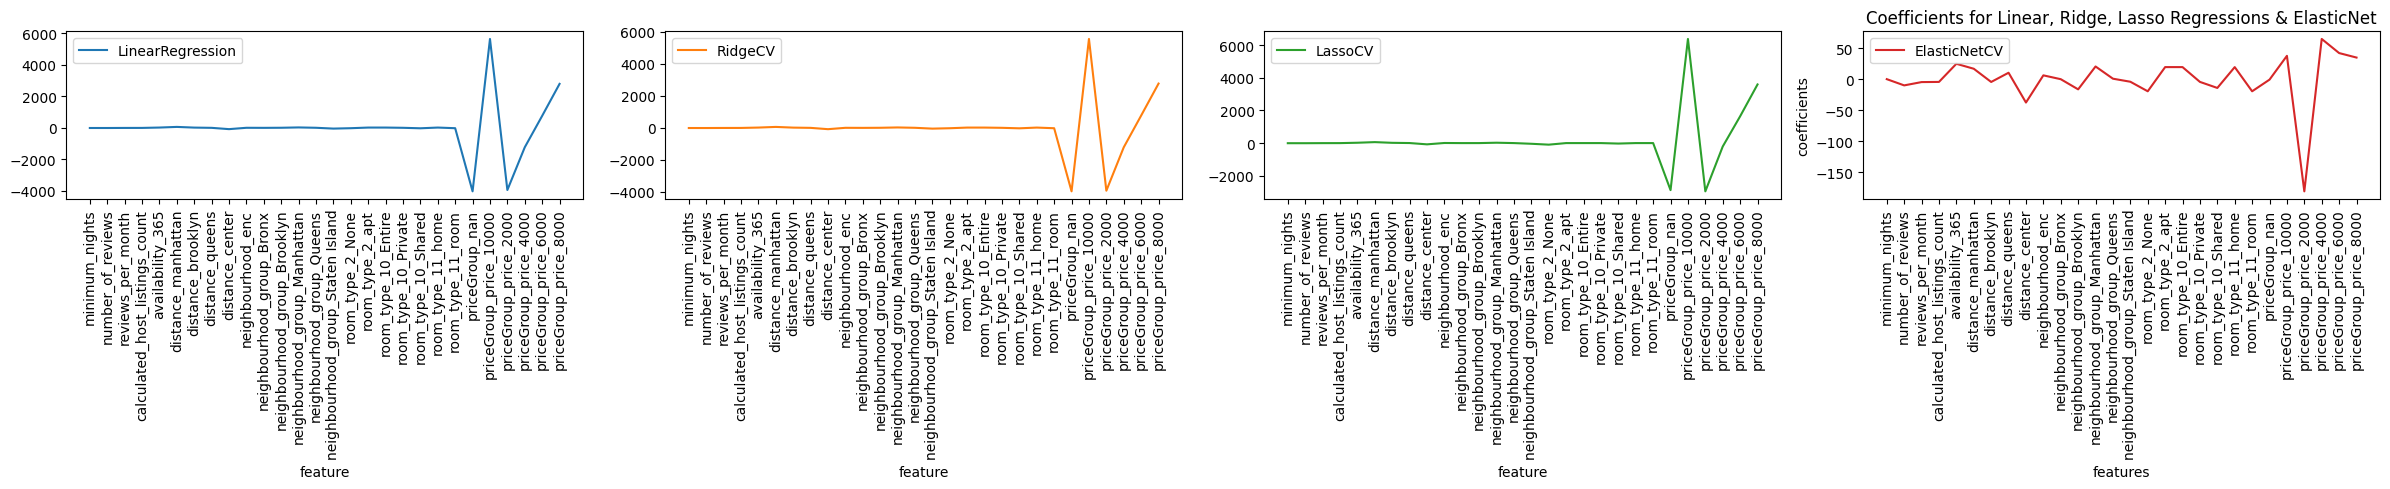

In [230]:
coeff = pd.DataFrame({'feature': ft.feature_names, 
                       'LinearRegression': coef_LinearRegression,
                       'RidgeCV': coef_RidgeCV,
                       'LassoCV': coef_LassoCV,
                       'ElasticNetCV': coef_ElasticNetCV})
coeff.set_index('feature', inplace=True)

ax = coeff.plot(subplots=True, layout=(1, 4), figsize = (24, 5))
plt.xticks(rotation='vertical')
plt.title("Coefficients for Linear, Ridge, Lasso Regressions & ElasticNet")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.tick_params(axis='x', labelrotation=45) # Rotate the labels
plt.subplots_adjust(bottom=0.25)

for axis in ax.flatten(): # Iterate over all axes objects
    axis.set_xticks(range(0,len(coeff.index)))
    axis.set_xticklabels(coeff.index, rotation=90)

plt.subplots_adjust(bottom=0.25, hspace=0.5)
plt.tight_layout()
plt.show()

На графиках видно что максимальное влияние оказывает признаки закодированные на основе priceGroup. Произошла утечка таргета!

А это значит оправдалось\подтвердилось моё опасение при проектировании "priceGroup - Решение интересное, но не будет ли "утечка таргета"? С одной стороны группы и не должно, но сдругой косвено цена задействована."

Уберём priceGroup и поробуем заново:

LinearRegression MSE = 34602.0510
LinearRegression MAE = 69.8607
LinearRegression MAPE = 36856802746355.2500
LinearRegression R2 = 0.1432
RidgeCV MSE = 34603.7343
RidgeCV MAE = 69.8574
RidgeCV MAPE = 36844546820496.3906
RidgeCV R2 = 0.1432
LassoCV MSE = 34604.5230
LassoCV MAE = 69.8174
LassoCV MAPE = 37138299082385.7109
LassoCV R2 = 0.1432
ElasticNetCV MSE = 34772.4846
ElasticNetCV MAE = 70.0115
ElasticNetCV MAPE = 37322125028578.0625
ElasticNetCV R2 = 0.1390


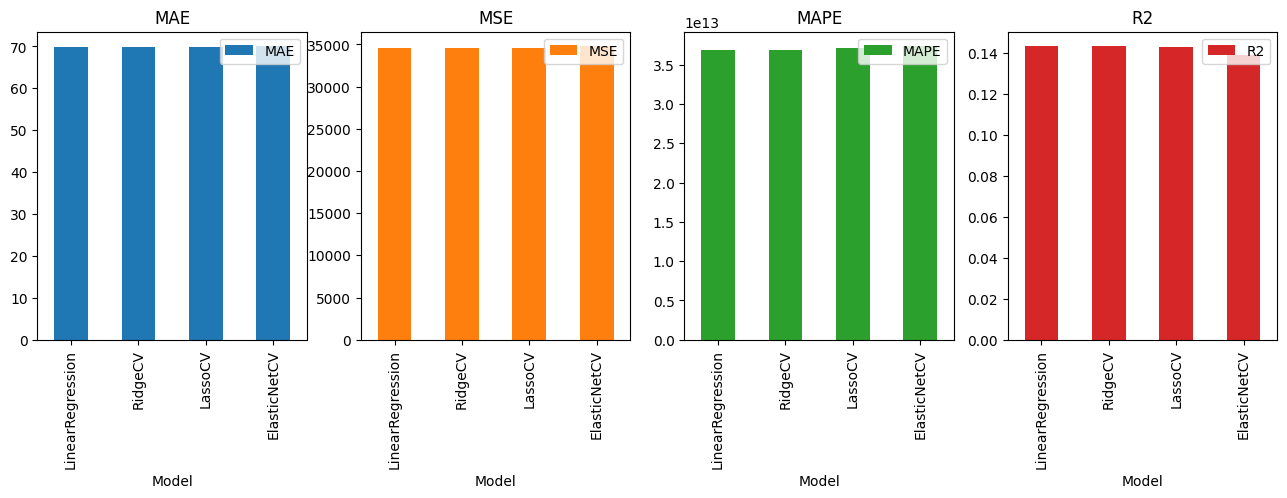

In [231]:
data = pd.read_csv("AB_NYC_2019.csv")

# 1. Отложите 30% данных для тестирования.
X_train, X_test, y_train, y_test = train_test_split(data, data['price'], random_state = 42, train_size=0.7, shuffle=True)

# 2. Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.

# Create an instance of the custom transformer
AB_NYC_2019 = AB_NYC_2019_class(columns_to_drop=['id', 'name', 'host_id', 'host_name', 'last_review'], regularization = 'LinearRegression', priceGroupUse = False)

pipeline = Pipeline([
    ('AB_NYC_2019', AB_NYC_2019)
])

ft = pipeline.fit_transform(X_train.copy(), y_train.copy())
y_pred = ft.predict(X_test.copy())

MSE_LinearRegression = mean_squared_error(y_test, y_pred)
MAE_LinearRegression = mean_absolute_error(y_test, y_pred)
MAPE_LinearRegression = mean_absolute_percentage_error(y_test, y_pred)
R2_LinearRegression = r2_score(y_test, y_pred)
coef_LinearRegression = ft.pipeline.named_steps['LinearRegression'].coef_

print("LinearRegression MSE = %.4f" % MSE_LinearRegression)
print("LinearRegression MAE = %.4f" % MAE_LinearRegression)
print("LinearRegression MAPE = %.4f" % MAPE_LinearRegression)
print("LinearRegression R2 = %.4f" % R2_LinearRegression)

AB_NYC_2019= AB_NYC_2019_class(columns_to_drop=['id', 'name', 'host_id', 'host_name', 'last_review'], regularization = 'RidgeCV', priceGroupUse = False)

pipeline = Pipeline([
    ('AB_NYC_2019', AB_NYC_2019)
])

ft = pipeline.fit_transform(X_train.copy(), y_train.copy())
y_pred = ft.predict(X_test.copy())

MSE_RidgeCV = mean_squared_error(y_test, y_pred)
MAE_RidgeCV = mean_absolute_error(y_test, y_pred)
MAPE_RidgeCV = mean_absolute_percentage_error(y_test, y_pred)
R2_RidgeCV = r2_score(y_test, y_pred)
coef_RidgeCV = ft.pipeline.named_steps['RidgeCV'].coef_

print("RidgeCV MSE = %.4f" % MSE_RidgeCV)
print("RidgeCV MAE = %.4f" % MAE_RidgeCV)
print("RidgeCV MAPE = %.4f" % MAPE_RidgeCV)
print("RidgeCV R2 = %.4f" % R2_RidgeCV)

AB_NYC_2019= AB_NYC_2019_class(columns_to_drop=['id', 'name', 'host_id', 'host_name', 'last_review'], regularization = 'LassoCV', priceGroupUse = False)

pipeline = Pipeline([
    ('AB_NYC_2019', AB_NYC_2019)
])

ft = pipeline.fit_transform(X_train.copy(), y_train.copy())
y_pred = ft.predict(X_test.copy())

MSE_LassoCV = mean_squared_error(y_test, y_pred)
MAE_LassoCV = mean_absolute_error(y_test, y_pred)
MAPE_LassoCV = mean_absolute_percentage_error(y_test, y_pred)
R2_LassoCV = r2_score(y_test, y_pred)
coef_LassoCV = ft.pipeline.named_steps['LassoCV'].coef_

print("LassoCV MSE = %.4f" % MSE_LassoCV)
print("LassoCV MAE = %.4f" % MAE_LassoCV)
print("LassoCV MAPE = %.4f" % MAPE_LassoCV)
print("LassoCV R2 = %.4f" % R2_LassoCV)

AB_NYC_2019= AB_NYC_2019_class(columns_to_drop=['id', 'name', 'host_id', 'host_name', 'last_review'], regularization = 'ElasticNetCV', priceGroupUse = False)

pipeline = Pipeline([
    ('AB_NYC_2019', AB_NYC_2019)
])

ft = pipeline.fit_transform(X_train.copy(), y_train.copy())
y_pred = ft.predict(X_test.copy())

MSE_ElasticNetCV = mean_squared_error(y_test, y_pred)
MAE_ElasticNetCV = mean_absolute_error(y_test, y_pred)
MAPE_ElasticNetCV = mean_absolute_percentage_error(y_test, y_pred)
R2_ElasticNetCV = r2_score(y_test, y_pred)
coef_ElasticNetCV = ft.pipeline.named_steps['ElasticNetCV'].coef_

print("ElasticNetCV MSE = %.4f" % MSE_ElasticNetCV)
print("ElasticNetCV MAE = %.4f" % MAE_ElasticNetCV)
print("ElasticNetCV MAPE = %.4f" % MAPE_ElasticNetCV)
print("ElasticNetCV R2 = %.4f" % R2_ElasticNetCV)

scores = pd.DataFrame({'Model': ['LinearRegression', 'RidgeCV', 'LassoCV', 'ElasticNetCV'], 
                       'MAE': [MAE_LinearRegression, MAE_RidgeCV, MAE_LassoCV, MAE_ElasticNetCV], 
                       'MSE': [MSE_LinearRegression, MSE_RidgeCV, MSE_LassoCV, MSE_ElasticNetCV], 
                       'MAPE': [MAPE_LinearRegression, MAPE_RidgeCV, MAPE_LassoCV, MAPE_ElasticNetCV], 
                       'R2': [R2_LinearRegression, R2_RidgeCV, R2_LassoCV, R2_ElasticNetCV]})

scores.plot.bar(subplots=True, layout=(1, 4), figsize=(16, 4), x='Model', y=['MAE', 'MSE', 'MAPE', 'R2'])
plt.show()

Теперь видим что ошибки практически одинаковые и лишь у ElasticNetCV чуть больше, а R2 нборот чуть меньше чем у остальных.

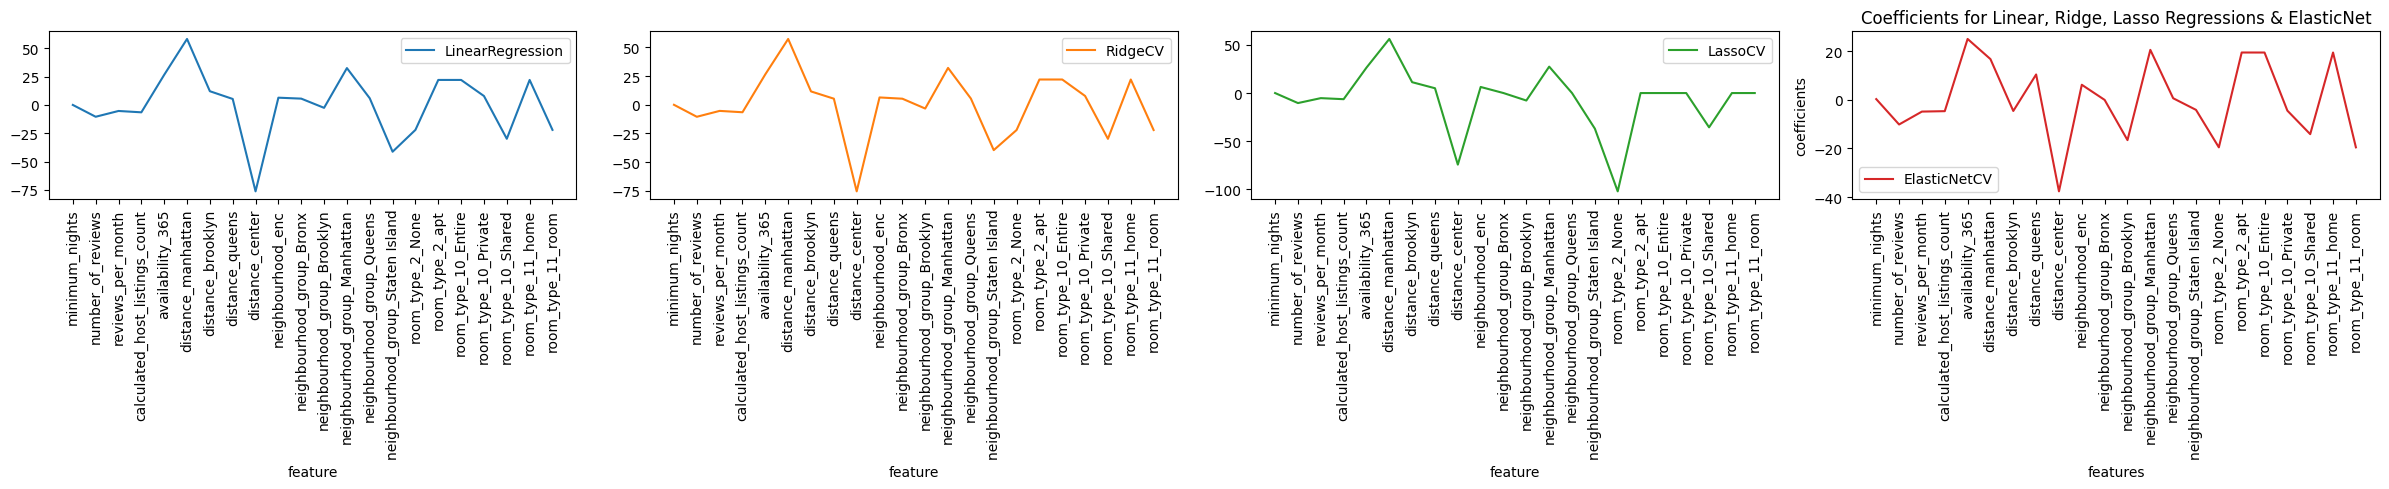

In [232]:
coeff = pd.DataFrame({'feature': ft.feature_names, 
                       'LinearRegression': coef_LinearRegression,
                       'RidgeCV': coef_RidgeCV,
                       'LassoCV': coef_LassoCV,
                       'ElasticNetCV': coef_ElasticNetCV})
coeff.set_index('feature', inplace=True)

ax = coeff.plot(subplots=True, layout=(1, 4), figsize = (24, 5))
plt.xticks(rotation='vertical')
plt.title("Coefficients for Linear, Ridge, Lasso Regressions & ElasticNet")
plt.ylabel("coefficients")
plt.xlabel("features")
plt.tick_params(axis='x', labelrotation=45) # Rotate the labels
plt.subplots_adjust(bottom=0.25)

for axis in ax.flatten(): # Iterate over all axes objects
    axis.set_xticks(range(0,len(coeff.index)))
    axis.set_xticklabels(coeff.index, rotation=90)

plt.subplots_adjust(bottom=0.25, hspace=0.5)
plt.tight_layout()
plt.show()

Теперь видно реальное влияние признаков!

Максимальный вклад расстояние до Манхэтана и до центра, вклад которых уменьшил ElasticNetCV. Второе место у соседство со Staten Island и видно как Lasso его уменьшил увеличив влияние неуказанного типа комнат.

Видим что ElasticNetCV разнообразил влияние фич больше чем остальные методы регуляризации.

#### Работа показала на практике как происходит утечка таргета и влияние регуляризации.

Интересно ваше мнение по вопросу:

data[data['calculated_host_listings_count'] >= 200]

Имеем 235 значений больше максимального. Теоретически их можно удалить или заменить на, например, максимальное в нормальной группе.

Вопрос: а нужно ли? Не убъём ли мы срез данных где важно количество жильцов?